# Starbucks Capstone Challenge

## PART 1. Project Definition

### Project Overview

Once in a while, Starbucks send out offers to their customers as a marketing strategy. Offers are of different types and every customers may receive different kinds and numbers of special offers. Starbucks keeps records of their customers' demographic data, offer portfolio and transcript data including customers' transactions and offers' sending out.

### Problem Statement

There are all kinds of problems to be solved using the data provided. Specifically for this project, we are going to focus on building a **classification machine learning model**. As we know, Starbucks send out offers with costs, so they are interested in knowing whether one offer will be completed or not by a certain user. If one offer is predicted to be 'not completed' in the future, then Starbucks can save money by not sending out this offer. Apart from making predictions, this model can also tell us how different features impact the final prediction. 

### Metrics

We will see in a later section that our data is not severely imbalanced. In other words, 54% of the offers are completed and 46% of them are not. Moreover, this is a binary classification problem, meaning that we only have two classes as our target - **True** for 'completed' and **False** for 'not completed'. Therefore, we are good to go with the simplest classification metrics - **accuracy**, which denotes the percentage of correct predictions.`

### Assumptions

Before we build any machine learning model, we should formulate some assumptions. These assumptions will come into help when we validate our model and can also spark ideas on feature engineering.

1. Customers with higher income are more likely to complete an offer because they are more capable of doing so.
2. Loyal customers are more likely to complete an offer. However, how to define a potential loyal customer is a problem itself. Maybe we should use feature engineering to create features that can reflect customers' loyalty.
3. Demographics as well as customer behavior data can both be helpful in building our model. 
4. Offer data such as offer type, difficulty to complete and reward can be useful.

### Dataset Overview (Credit to Udacity)

This data set is a simplified version of the real Starbucks app because we assume Starbucks only sells one product here. All offers are for that only one product.
The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational. BOGO standsfor '**B**uy **O**ne **G**et **O**ne'.
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in **days**
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in **hours** since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### Examples

Here we will see some examples to better understand our data:

1. An customer received an BOGO offer of 10 dollars. This offer needed to be completed within 7 days. This customer finally reached 10 dollars at the 8th day, so this customer did NOT complete this offer.
2. An customer received an BOGO offer of 10 dollars. This customer did not view this offer but reached 10 dollars at the 6th day. This user managed to complete this offer WITHOUT viewing it.
3. An customer might receive the same offer several times. Therefore, customer_id + offer_id is NOT the unique identifier in the transcript data. In other words, there can be multiple records with the same (customer_id, offer_id) combination.

## PART 2. Data Exploration & Cleansing

### Import packages & data

In [127]:
import pandas as pd
import numpy as np
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Basic Exploration

#### profile

In [23]:
print('There are {} unique customers.'.format(profile.shape[0]))

There are 17000 unique customers.


#### portfolio

In [24]:
print('There are {} different offers.'.format(portfolio.shape[0]))
print('There are {} BOGO offers.'.format(portfolio[portfolio['offer_type'] == 'bogo'].shape[0]))
print('There are {} discount offers.'.format(portfolio[portfolio['offer_type'] == 'discount'].shape[0]))
print('There are {} informational offers.'.format(portfolio[portfolio['offer_type'] == 'informational'].shape[0]))

There are 10 different offers.
There are 4 BOGO offers.
There are 4 discount offers.
There are 2 informational offers.


#### transcript

In [25]:
print("There are {} 'offer received' records, {} 'offer viewed' records and {} 'offer completed' records.".format(sum(transcript['event'] == 'offer received'),
                                                                                                                 sum(transcript['event'] == 'offer viewed'),
                                                                                                                 sum(transcript['event'] == 'offer completed')))




There are 76277 'offer received' records, 57725 'offer viewed' records and 33579 'offer completed' records.


### Data Quality Check

In [26]:
# missing value
print(portfolio.isna().sum()) # all zeros
print(transcript.isna().sum()) # all zeros
print(profile.isna().sum())# 2,175 missing values in gender & income - 12.79%, probably 'NA' as a new category

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64
person    0
event     0
value     0
time      0
dtype: int64
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


From what we can see here, there are no missing values in the 'portfolio' and 'transcript' data tables. However, 2,175 missing values present in the 'gender' and 'income' variables in the 'profile' data table. In other words, 12.79% percent of the records in the 'profile' table have missing values, so we cannot simply remove these rows. We will handle this problem later in the data wrangling section.

In [27]:
len(profile[(profile['income'].isna()) & (profile['gender'].isna())])

2175

The number of rows with missing values both in 'gender' and 'income' is exactly 2,175. That means all users who don't have gender recorded also don't have income value. This kind of missing is coincident and we must do something to record this later.

In [125]:
# data types 
print('portfolio: \n',portfolio.dtypes,'\n')
print('transaction: \n\n',transcript.dtypes,'\n') # value is 'object' because it varies depending on 'event'
print('profile: \n\n',profile.dtypes,'\n') # 'became_member_on' need to be date type; 

portfolio: 
 reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object 

transaction: 

 person     object
event      object
value      object
time      float64
dtype: object 

profile: 

 gender                      object
age                         object
id                          object
became_member_on    datetime64[ns]
income                      object
dtype: object 



There are two things notable here: first, 'value' variable in the 'transcript' table is of object type. That is because this variable varies depending on whether this record is about transaction or an offer. If it is a transaction record, then the value is a dictionary with 'amount' as the key. If it is an offer record, then that key is either 'offer id' or 'offer_id'.

In [29]:
transcript['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

Second, 'became_member_on' in the 'profile' table is not of date type. We have to change that date type with correct format.

In [30]:
profile['became_member_on'].head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

Text(0.5, 1.0, 'Distribution of customer age')

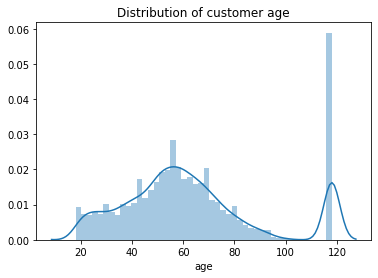

In [128]:
# outlier
sns.distplot(profile['age']).set_title('Distribution of customer age')

There are a few users with age of 118. If we dig further, these users are exactly those users without 'gender' and 'income' values. We have to encode these very high ages as 'missing' later.

Text(0.5, 1.0, 'Count of different customer gender')

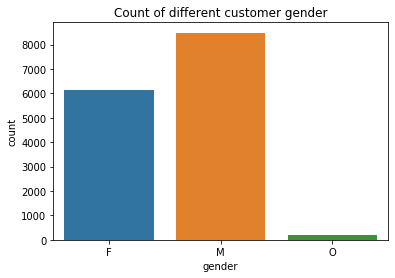

In [129]:
sns.countplot(profile['gender']).set_title('Count of different customer gender')

In [33]:
profile[profile['gender'] == 'O'].shape[0]/profile.shape[0]

0.012470588235294117

A few users have gender of 'O'. We are not sure whether they belong to the transgender group or it also means 'missing'. Luckily, we only have 1% users with gender of 'O', so we might as well keep it as its own category.

### Data Cleansing

We observed a few problems within our data sets in the previous section. Let's deal with them here.

In [34]:
# replace gender - None & age - 118 & income - NaN with 'Missing'
profile['gender']= profile['gender'].fillna('missing')
profile['age']= profile['age'].apply(lambda x:'missing' if x==118 else x)
profile['income'] = profile['income'].fillna('missing')

In [35]:
# convert 'became_member_on' to the right type and format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')

In [36]:
# convert transcript time from hours to days
transcript['time'] = transcript['time']/24

In [37]:
# let's take a look at our data after cleaning
profile.head()

,gender,age,id,became_member_on,income
0,missing,missing,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,missing
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000
2,missing,missing,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,missing
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000
4,missing,missing,a03223e636434f42ac4c3df47e8bac43,2017-08-04,missing


In [38]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0.0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0.0


In [39]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


## PART 3. Data Analysis

### Data Wrangling

In the previous part, we have corrected the potential errors in our data sets. Starting from this point, we will dive into the analysis. Before we build any machine learning model, we first need to think about how to play with our data to make it look nicer. To be specific, we probably want to join the information from the three tables into one. For that one table, we want every row to be a record saying 'some user receives some offer and ends up completing/not completing this offer'. 

In [55]:
users = profile['id'] # all user_ids
subset_users = profile['id']# subset all users
subset_transcript = transcript[transcript['person'].isin(subset_users)] # subset records related to subset users

To better illustrate the functions build below, I sample only 100 users to reduce execution time of these functions greatly and we can quickly see how our functions perform.

In [41]:
def create_users_offer_dict(users, transcript):
    '''
    INPUT:
    user: a list of user_ids
    transcript: all or part of the transcript data provided
    
    OUTPUT:
    A dictionary: Each key is an user_id, each value is a list of (offer_id, receive_time)
    '''
    
    start_time = time.time()
    func1_cnt = 0 # initialize a counter
    users_offer = {} # initialize an empty dict
    ''' Loop through all the users'''
    for user in users: 
        func1_cnt += 1
        if func1_cnt % 1000 == 0: # checkpoint for every 1,000 iterations
            print('Creating user-offer dictonary: Processed {} users.'.format(func1_cnt))
        users_offer[user] = []
        '''For each offer, record its offer_id and receive_time'''
        for index,row in transcript[(transcript['person'] == user) &(transcript['event'] == 'offer received')].iterrows():
            try: #if try runs successfully, it is an offer record
                offer_id = row['value']['offer id']
                receive_time = row['time']
                users_offer[user].append((offer_id,receive_time)) # tuple - (offer_id, receive_time)
            except: # if try gives an error, that means it meets a transaction record, so continue
                continue
    end_time = time.time()
    print('create_users_offer function runs for:{} seconds'.format(end_time-start_time)) # print out the execution time
    return users_offer

In [42]:
#create_users_offer_dict(subset_users, subset_transcript)

In [43]:
def create_clean_transcript(transcript):
    '''
    INPUT:
    transcript: all or part of the transcript data provided
    
    OUTPUT:
    offer_transcript: part of the transcript data that is related to offers
    transaction: part of the transcript data that is related to transaction
    '''
    start_time = time.time()
    '''offer_transcript'''
    offer_transcript = transcript[transcript['event'] != 'transaction'] # remove transaction data
    offer_transcript['value'] = offer_transcript['value'].apply(lambda x:list(x.values())[0]) #extract value from a dict
    offer_transcript.rename(columns={'value':'offer_id'},inplace=True) # rename the created column
    '''transaction'''
    transaction = transcript[transcript['event'] == 'transaction'] # keep transaction data
    transaction['value'] = transaction['value'].apply(lambda x:list(x.values())[0]) # extract value from a dict
    transaction.rename(columns={'value':'amount'},inplace=True) # rename the created column
    end_time = time.time()
    print('create_clean_transcript function runs for:{} seconds'.format(end_time-start_time)) # print out the execution time
    return offer_transcript, transaction


In [44]:
#offer_transcript, transaction = create_clean_transcript(subset_transcript)
#offer_transcript

In [45]:
def count_user_offer(users, transcript):
    '''
    INPUT:
    users: a list of user_ids
    transcript: all or part of the transcript data provided
    offer_transcript
    
    OUTPUT:
    new_offer_transcript: Same to the original offer_transcript except one new column - 'count'
    This column is the id of an offer received by this person.
    (user_id, count) is the unique identifier of this table
    '''
    start_time = time.time()
    func2_cnt = 0 #initialize a counter
    offer_transcript, transaction = create_clean_transcript(transcript) # split the transcript data 
    new_offer_transcript = pd.DataFrame() #initialize a new dataframe
    users_offers = create_users_offer_dict(users, transcript) # create the user_id:(offer_id, receive_time) dict
    '''Loop through every user'''
    for user in users_offers.keys(): 
        func2_cnt += 1
        if func2_cnt % 1000 == 0: # checkpoint for every 1000 iterations
            print('Labeling offers received by each user: Processed {} users.'.format(func2_cnt))
        user_transcript = offer_transcript[offer_transcript['person'] ==user].reset_index(drop=True) # transcript data of this user
        for index, row in user_transcript.iterrows():
            if row['event'] == 'offer received': #if this is a newly received offer, add one to count
                user_transcript.loc[index,'count'] = users_offers[row['person']].index((row['offer_id'],row['time'])) + 1
            else: #if not, count is the max value out of previous counts
                user_transcript.loc[index,'count'] = max(user_transcript[user_transcript['offer_id'] == row['offer_id']]['count'])
        new_offer_transcript = pd.concat([new_offer_transcript, user_transcript],axis=0) # continuously add in a user's transcript data 
    end_time = time.time()
    print('count_user_offer function runs for:{} seconds'.format(end_time-start_time)) # print the execution time
    return new_offer_transcript

In [46]:
#count_user_offer(subset_users, subset_transcript)

In [51]:
def create_user_offer_df(users,profile,transcript,portfolio):
    '''
    INPUT:
    users: a list of user_ids
    transcript: all or part of the transcript data provided
    portfolio: offer portfolio data provided
    profile: customer profile data provided
    
    OUTPUT:
    final_df: a dataframe ready to be put into a machine learning model
    For this dataframe, each row is a record of some customer receiving some offer and ending up completing it or not.
    Apart from that, customer profile data and portfolio data are also joined.
    
    offer_transcript: part of the transcript data that is related to offers
    transaction: part of the transcript data that is related to transaction
    '''
    start_time = time.time()
    offer_transcript, transaction = create_clean_transcript(transcript)
    new_offer_transcript = count_user_offer(users, transcript) # create a transcript dataframe with 'count' column
    final_df = pd.pivot_table(new_offer_transcript, values='time', index=['person', 'offer_id','count'],
                        columns=['event'], aggfunc=np.mean, fill_value=np.nan) #pivot the dataframe
    final_df = final_df.reset_index() #reset the index
    final_df.rename(columns={'offer completed':'offer_completed_time',
                      'offer received':'offer_received_time',
                     'offer viewed':'offer_viewed_time'},inplace=True) #rename the columns
    # join in portfolio information
    final_df = final_df.merge(portfolio, left_on='offer_id',right_on='id').drop(columns = ['id'])
    # join in profile information
    final_df = final_df.merge(profile, left_on = 'person',right_on = 'id').drop(columns=['id'])
 
    end_time = time.time()
    print('create_user_offer_df(final) function runs for:{} seconds'.format(end_time-start_time)) # print out the execution time
    
    return final_df, offer_transcript, transaction

In [56]:
processed_final_df, offer_transcript, transaction  = create_user_offer_df(subset_users,profile,subset_transcript,portfolio)

C:\Users\zuobe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\zuobe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


create_clean_transcript function runs for:0.300229549407959 seconds
create_clean_transcript function runs for:0.32774996757507324 seconds
Creating user-offer dictonary: Processed 1000 users.
Creating user-offer dictonary: Processed 2000 users.
Creating user-offer dictonary: Processed 3000 users.
Creating user-offer dictonary: Processed 4000 users.
Creating user-offer dictonary: Processed 5000 users.
Creating user-offer dictonary: Processed 6000 users.
Creating user-offer dictonary: Processed 7000 users.
Creating user-offer dictonary: Processed 8000 users.
Creating user-offer dictonary: Processed 9000 users.
Creating user-offer dictonary: Processed 10000 users.
Creating user-offer dictonary: Processed 11000 users.
Creating user-offer dictonary: Processed 12000 users.
Creating user-offer dictonary: Processed 13000 users.
Creating user-offer dictonary: Processed 14000 users.
Creating user-offer dictonary: Processed 15000 users.
Creating user-offer dictonary: Processed 16000 users.
Creatin

In [58]:
processed_final_df.head()

,person,offer_id,count,offer_completed_time,offer_received_time,offer_viewed_time,reward,channels,difficulty,duration,offer_type,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,5.0,24.00,24,NaN,2,"[web, email, mobile]",10,7,discount,M,33,2017-04-21,72000
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,2.0,NaN,14,15.5,0,"[web, email, mobile]",0,4,informational,M,33,2017-04-21,72000
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,NaN,7,8.0,0,"[email, mobile, social]",0,3,informational,M,33,2017-04-21,72000
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,3.0,17.25,17,19.0,5,"[web, email, mobile, social]",5,5,bogo,M,33,2017-04-21,72000
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,4.0,22.00,21,22.5,2,"[web, email, mobile, social]",10,10,discount,M,33,2017-04-21,72000


Before we start feature engineering, we have some last wrangling to do with the data we have.

In [59]:
all_data = processed_final_df
all_data['complete_or_not']= -all_data['offer_completed_time'].isna() # create target column
all_data['view_or_not'] = -all_data['offer_viewed_time'].isna() 
all_data = all_data[all_data['offer_type'] != 'informational']# informational offer won't be completed, so we don't need them
all_data['receive_count'] = all_data['count'] - 1 # the number of offers reveiced before
all_data = all_data.sort_values('offer_received_time') # sort df by 'time' in ascending order
all_data.reset_index(drop=True, inplace=True)
X = all_data.drop(columns = ['complete_or_not']) # split into X and y
y = all_data['complete_or_not']

C:\Users\zuobe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [60]:
# train test split
num_row = all_data.shape[0]
train_index = round((num_row - 1)*0.7)
X_train = X.iloc[0:train_index,:]
y_train = y[0:train_index]
X_test = X.iloc[train_index:,:]
y_test = y[train_index:]

### Model 1

Now we need to think about what features to use in our model. My first thought is user demographics might be very useful, so let's start with that.

In [62]:
def feature_eng_1(old_df,all_data,transaction):
    '''
    INPUT:
    old_df: X_train ready to be engineered
    all_data: all data before train & test split
    transaction: transaction dataframe 
    
    OUTPUT:
    df: new X_train after feature engineering
    '''
    df = old_df.copy() # create a copy of the original X_train
    df.drop(columns =['count'],inplace=True) # drop unnecessary 'count' column
    # create binary columns for channels
    df['channel_web'] = df['channels'].apply(lambda x:1 if 'web' in x else 0)
    df['channel_email']= df['channels'].apply(lambda x:1 if 'email' in x else 0)
    df['channel_mobile']= df['channels'].apply(lambda x:1 if 'mobile' in x else 0)
    df['channel_social']= df['channels'].apply(lambda x:1 if 'social' in x else 0)
    # create a new variable for the number of channels that an offer is sent through
    df['num_of_channels'] = df['channel_web'] + df['channel_email'] + df['channel_mobile']+df['channel_social']
    df.drop(columns=['channels'],inplace=True) # drop the original channels column

    df['member_month'] = df['became_member_on'].dt.month # extract month from date data
    df['member_year'] = df['became_member_on'].dt.year # extract year from date data
    df.drop(columns=['became_member_on'],inplace=True) # drop the original date column

    # create a binary column named 'missing'
    # value = 1 if this record comes from an user with missing values in age, gender and income
    df['missing'] = df['income'].apply(lambda x:1 if x=='missing' else 0)
    
    df = pd.concat([df,pd.get_dummies(df['gender'], prefix = 'gender_')],axis = 1) # create binary columns for 'gender'
    df.drop(columns = ['gender'], inplace=True) # drop the original 'gender' column
    
    df = pd.concat([df,pd.get_dummies(df['offer_type'], prefix = 'offer_type_')],axis = 1) # create binary columns for 'offer_type'
    df.drop(columns = ['offer_type'], inplace=True) # drop the original 'offer_type' column

    # impute 'age' and 'income' by median value
    median_age = df[df['age']!='missing']['age'].median()
    median_income =df[df['income']!='missing']['income'].median()
    df['age'] = df['age'].apply(lambda x: median_age if x=='missing' else x)
    df['income'] = df['income'].apply(lambda x:median_income if x=='missing' else x)

    # reset index
    df = df.reset_index(drop=True)
    
    # drop unnecessary columns
    df.drop(columns = ['person','offer_id','view_or_not',
                       'offer_completed_time','offer_received_time', 'offer_viewed_time'],inplace=True)
    return df

In [63]:
# create new X_train and X_test
new_X_train_1 = feature_eng_1(X_train,all_data,transaction)
new_X_test_1 = feature_eng_1(X_test,all_data,transaction)

In [64]:
# fit a random forest classifier
clf_1 = RandomForestClassifier(random_state=1)
clf_1.fit(new_X_train_1,y_train)
y_pred_1 = clf_1.predict(new_X_test_1)

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    INPUT:
    cm: a confusion matrix object created by confusion_matrix() function
    classes: a list of classes names
    normalize: True if you want to normalize the values shown in the matrix
    title: title of the plot
    cmap: color scheme to be used
    
    OUTPUT:
    A confusion matrix plot
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title) # customize title
    plt.colorbar() # display the colorbar
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0) # customize x ticks
    plt.yticks(tick_marks, classes, rotation=0) # customize y ticks

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

The accuracy of this classifier is 0.7087315022115437.


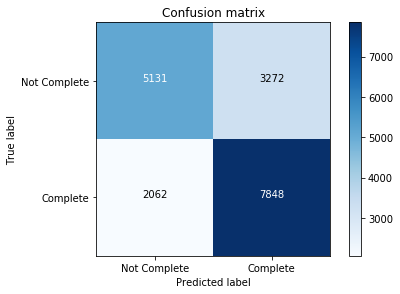

In [5]:
confusion_mtx = confusion_matrix(y_test, y_pred_1) # create confusion_matrix object
plot_confusion_matrix(confusion_mtx, classes = ['Not Complete','Complete'])  # plot the confusion matrix
print('The accuracy of this classifier is {}.'.format(accuracy_score(y_pred_1,y_test))) # print accuracy_score

In [8]:
def feature_importance_plot(model,num_of_features,new_X_train):
    '''
    INPUT:
    model: a trained machine learning model
    num_of_features: the number of top features of interest
    new_X_train: the new X_train dataframe after feature engineering
    
    OUTPUT:
    A feature importance bar plot
    '''
    importances = model.feature_importances_ # extract feature importance from the model object
    indices = np.argsort(importances)[::-1] # sort feature importance in descending order
    plt.figure(figsize=(10, 4))
    plt.title("Feature importances") 
    plt.bar(range(num_of_features), importances[indices][:num_of_features]
            , align="center")
    plt.xlabel('Feature Names')
    plt.ylabel('Feature Importance')
    plt.xticks(range(num_of_features), new_X_train.columns[indices][:num_of_features])
    plt.xlim([-1, num_of_features])
    plt.show()

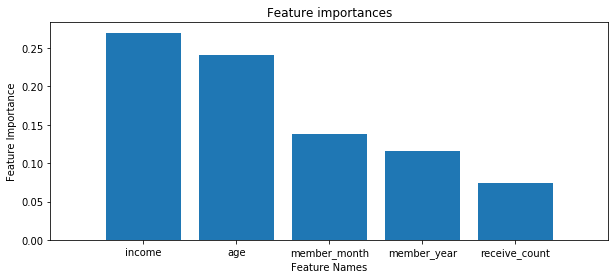

In [9]:
feature_importance_plot(clf_1,5,new_X_train_1) # create the feature importance plot

### Model Two 

Our first model's performance wasn't that good with 70% accuracy. Let's rethink about good features. I have read in *A Collection of Data Science Take-Home Challenges* by Giulio Palombo that user behavior data can be more important than demographics. This is because any user behavior speaks for itself and more importantly reveals information on timing. That being said, let's incorportate some user behavior features into our model to see how it goes.

In [69]:
def compute_previous_value(df,all_data,transaction):
    '''
    INPUT:
    df: X_train ready to be engineered
    all_data: all data before train & test split
    transaction: transaction dataframe 
    
    OUTPUT:
    df: the original df with 3 extra columns
    sum_amount: how much money this customer have spent before this offer record
    complete_amount: the number of offers previously completed by this customer
    view_count: the number of offers previously viewed by this customer
    '''
    start_time = time.time()
    func3_cnt = 0
    for index,row in df.iterrows():
        func3_cnt += 1
        if func3_cnt % 2000 == 0: # checkpoint for every 2,000 iterations
            print('{} lines finished.'.format(func3_cnt))
        df.loc[index,'sum_amount'] = transaction[(transaction['person'] == row['person']) & (transaction['time'] < row['offer_received_time'])]['amount'].sum()
        df.loc[index,'complete_count'] = all_data[(all_data['person'] == row['person']) & (all_data['receive_count'] < row['receive_count'])]['complete_or_not'].sum()
        df.loc[index,'view_count'] = all_data[(all_data['person'] == row['person']) & (all_data['receive_count'] < row['receive_count'])]['view_or_not'].sum()    
    end_time = time.time()
    print('Calculating complete_count takes {} seconds.'.format(end_time-start_time))
    return df

In [70]:
def feature_eng_2(old_df,all_data,transaction):
    '''
    INPUT:
    old_df: X_train ready to be engineered
    all_data: all data before train & test split
    transaction: transaction dataframe 
    
    This function is the same to feature_eng_1 funtion except that this one incorporates create_previous_value function
    
    OUTPUT:
    df: new X_train after feature engineering
    '''
    
    df = old_df.copy()
    df.drop(columns =['count'],inplace=True)
    
    df['channel_web'] = df['channels'].apply(lambda x:1 if 'web' in x else 0)
    df['channel_email']= df['channels'].apply(lambda x:1 if 'email' in x else 0)
    df['channel_mobile']= df['channels'].apply(lambda x:1 if 'mobile' in x else 0)
    df['channel_social']= df['channels'].apply(lambda x:1 if 'social' in x else 0)
    df['num_of_channels'] = df['channel_web'] + df['channel_email'] + df['channel_mobile']+df['channel_social']
    df.drop(columns=['channels'],inplace=True)

    df['member_month'] = df['became_member_on'].dt.month
    df['member_year'] = df['became_member_on'].dt.year
    df.drop(columns=['became_member_on'],inplace=True)

    # mark all records coming from the users with missing values
    df['missing'] = df['income'].apply(lambda x:1 if x=='missing' else 0)

    # dummy 'gender' column
    df = pd.concat([df,pd.get_dummies(df['gender'], prefix = 'gender_')],axis = 1)
    df.drop(columns = ['gender'], inplace=True)
    # dummy 'offer_type' column
    df = pd.concat([df,pd.get_dummies(df['offer_type'], prefix = 'offer_type_')],axis = 1)
    df.drop(columns = ['offer_type'], inplace=True)

    #impute 'age' and 'income' by median value
    median_age = df[df['age']!='missing']['age'].median()
    median_income =df[df['income']!='missing']['income'].median()
    df['age'] = df['age'].apply(lambda x: median_age if x=='missing' else x)
    df['income'] = df['income'].apply(lambda x:median_income if x=='missing' else x)

    # reset index
    df = df.reset_index(drop=True)
    
    # run the compute_previous_value function - the only different part from the feature_eng_1 function
    df['complete_count'] = None
    df = compute_previous_value(df,all_data,transaction)
    df['complete_count'] = df['complete_count'].astype(int)
    
    # drop unnecessary columns
    df.drop(columns = ['person','offer_id','view_or_not',
                       'offer_completed_time','offer_received_time', 'offer_viewed_time'],inplace=True)
    return df

In [71]:
# create new X_train and X_test
new_X_train_2 = feature_eng_2(X_train,all_data,transaction)
new_X_test_2 = feature_eng_2(X_test,all_data,transaction)

2000 lines finished.
4000 lines finished.
6000 lines finished.
8000 lines finished.
10000 lines finished.
12000 lines finished.
14000 lines finished.
16000 lines finished.
18000 lines finished.
20000 lines finished.
22000 lines finished.
24000 lines finished.
26000 lines finished.
28000 lines finished.
30000 lines finished.
32000 lines finished.
34000 lines finished.
36000 lines finished.
38000 lines finished.
40000 lines finished.
42000 lines finished.
Calculating complete_count takes 985.8864884376526 seconds.
2000 lines finished.
4000 lines finished.
6000 lines finished.
8000 lines finished.
10000 lines finished.
12000 lines finished.
14000 lines finished.
16000 lines finished.
18000 lines finished.
Calculating complete_count takes 438.3746304512024 seconds.


In [72]:
# fit a random forest classifier
clf_2 = RandomForestClassifier(random_state=1)
clf_2.fit(new_X_train_2,y_train)
# make predictions
y_pred_2 = clf_2.predict(new_X_test_2)

The accuracy of this classifier is: 0.7730027849068968.


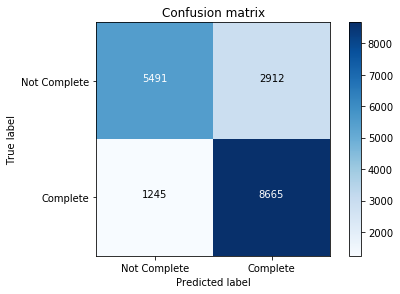

In [10]:
confusion_mtx = confusion_matrix(y_test, y_pred_2) # create a confusion matrix object
plot_confusion_matrix(confusion_mtx, classes = ['Not Complete','Complete']) # plot the confusion matrix
print('The accuracy of this classifier is: {}.'.format(accuracy_score(y_pred_2,y_test))) # print the accuracy_score

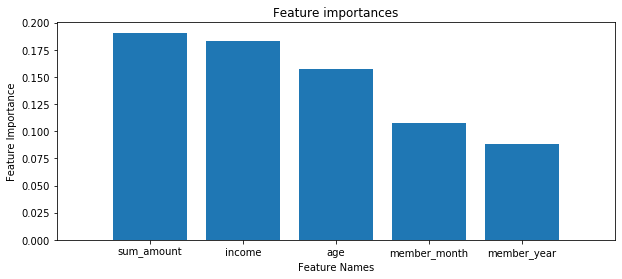

In [11]:
feature_importance_plot(clf_2,5,new_X_train_2) # create the feature importance plot

### Model Evaluation and Validation

As we put it earlier, classification accuracy is the primary metric used to evaluate our model. This is because we have a balanced dataset. By executing 'y_train.value_counts()' and 'y_test.value_counts()' commands, we can see the number of observations with True is approximately the same to the number of observations with False.

In [14]:
print(y_train.value_counts())
print(y_test.value_counts())

True     23191
False    19538
Name: complete_or_not, dtype: int64
True     9910
False    8403
Name: complete_or_not, dtype: int64


The accuracy of the **first** model is 0.7087. The top 5 important features are income, age, date columns and receive_count.The accuracy of the **second** model is 0.7730. the top 5 features are sum_amount, income, age and date columns.

Remember the difference between the two offers is that we add customer previous behavior features into the **second** model, which leads to an increase on accuracy. The new 'sum_amount' variable turns out to be very beneficial to our model. This is an example of good feature engineering! Thus in further interpretation, we only focus on the **second** model.

#### Is our model trustworthy? 

To validate our model and better sell it to the decision makers, we should think from a business standpoint whether our model makes sense or not. One good way is to check if the results of our model is counterintuitive. If it is, we either just discovered something new and groundbreaking or we literally made something very wrong (most of the time...). Remember at the very beginning we made some assumptions, we can start from there.

In [20]:
# let's put our predictions and the original test set together
result_df = pd.concat([new_X_test_2,y_test.reset_index(drop=True),pd.Series(y_pred_2)],axis=1).rename(columns={0:'pred'})
result_df

,reward,difficulty,duration,age,income,receive_count,channel_web,channel_email,channel_mobile,channel_social,...,gender__O,gender__missing,offer_type__bogo,offer_type__discount,complete_count,sum_amount,view_count,index,complete_or_not,pred
0,10,10,7,40.0,57000.0,2.0,0,1,1,1,...,0,0,1,0,2,54.43,2.0,42729,True,True
1,5,20,10,49.0,85000.0,2.0,1,1,0,0,...,0,0,0,1,1,25.53,1.0,42730,False,True
2,3,7,7,28.0,65000.0,2.0,1,1,1,1,...,0,0,0,1,1,37.12,2.0,42731,False,True
3,10,10,7,63.0,92000.0,1.0,0,1,1,1,...,0,0,1,0,1,126.92,1.0,42732,True,True
4,5,5,7,60.0,47000.0,4.0,1,1,1,0,...,0,0,1,0,4,111.31,4.0,42733,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18308,2,10,10,58.0,110000.0,2.0,1,1,1,1,...,0,0,0,1,2,95.21,2.0,61037,True,True
18309,10,10,7,52.0,56000.0,3.0,0,1,1,1,...,0,0,1,0,2,151.03,2.0,61038,True,True
18310,10,10,7,56.0,55000.0,5.0,0,1,1,1,...,0,0,1,0,5,135.83,5.0,61039,True,True
18311,10,10,5,46.0,31000.0,5.0,1,1,1,1,...,0,0,1,0,1,111.31,1.0,61040,True,False


In [105]:
print('The median income of all customers in the test set:',result_df['income'].median())
print('The median income of customers predicted to complete an offer in the test set:',result_df[result_df['pred'] == True]['income'].median())
print('The mean income of all customers in the test set:',result_df['income'].mean())
print('The mean income of customers predicted to complete an offer in the test set:',result_df[result_df['pred'] == True]['income'].mean())

The median income of all customers in the test set: 64000.0
The median income of customers predicted to complete an offer in the test set: 69000.0
The mean income of all customers in the test set: 65174.35701414296
The mean income of customers predicted to complete an offer in the test set: 69781.54962425499


The median and mean income of customers predicted to complete an offer are higher than those of all customers. Our model assignes people with higher income high probability to complete an offer, which is consistent with one of our assumptions that these people have more capability to complete an offer.

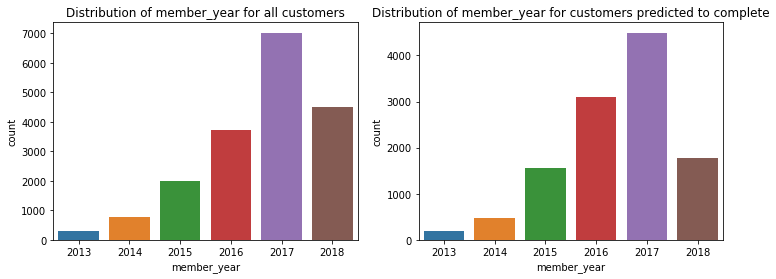

In [119]:
fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
sns.countplot(result_df['member_year'],ax=ax1).set_title('Distribution of member_year for all customers')
sns.countplot(result_df[result_df['pred'] == True]['member_year'],ax=ax2).set_title('Distribution of member_year for customers predicted to complete')
plt.show()

These two countplots look similar. However, if we look closer, we can notice that the proportions of 2015 and 2016 members are higher in the right plot. That means our model thinks customers who became members in 2015 and 2016 are more likely to complete an offer than others, especially than those 2018 members. Our model has started formulating its own definition of loyal customers.

In [120]:
print('The median income of all customers in the test set:',result_df['sum_amount'].median())
print('The median income of customers predicted to complete an offer in the test set:',result_df[result_df['pred'] == True]['sum_amount'].median())
print('The mean income of all customers in the test set:',result_df['sum_amount'].mean())
print('The mean income of customers predicted to complete an offer in the test set:',result_df[result_df['pred'] == True]['sum_amount'].mean())

The median income of all customers in the test set: 46.47
The median income of customers predicted to complete an offer in the test set: 86.82
The mean income of all customers in the test set: 74.3809266641182
The mean income of customers predicted to complete an offer in the test set: 108.12670553684032


Similar to what we have found about income, the median and mean 'sum_amount' of customers predicted to complete an offer are higher than those of all customers. This makes sense because these customers are using their actions to prove themselves as loyal customers and our model has noticed that.

As stated above, our model's performance is not counterintuitive, which makes whoever you will present to less reluctant and more willing to accept it.

#### Where does our model make mistakes?

Finding out where the current model is making mistakes is super helpful to refine a model. It can at least trigger some ideas on what other data to collect and what other features to create if possible.

In [123]:
# wrong predictions
result_df[(result_df['pred'] == True) & (result_df['complete_or_not'] ==0)].sort_values(['sum_amount'])[['age','income','complete_count',
                                                                                                         'sum_amount','view_count','member_year']].head(10)

,age,income,complete_count,sum_amount,view_count,member_year
5829,64.0,89000.0,0,0.0,4.0,2018
17828,60.0,113000.0,0,0.0,0.0,2015
7472,59.0,86000.0,0,0.0,2.0,2018
5347,60.0,112000.0,0,0.0,1.0,2017
2920,49.0,74000.0,0,0.0,1.0,2015
14690,59.0,113000.0,0,0.0,1.0,2018
11286,46.0,61000.0,0,0.0,3.0,2016
13080,79.0,77000.0,0,0.0,1.0,2016
13668,51.0,101000.0,0,0.0,1.0,2018
13036,78.0,79000.0,0,0.0,0.0,2015


These are ten examples where our model predict as 'complete' but actually they didn't. I have sorted this list by 'sum_amount' in asending order. Although all the customers haven't completed an offer or even spent any money before, they are still predicted as 'complete'. So what happened? First, 9 customer out of 10 have an income higher than the mean/median value we saw before, so it explains. Second, for customer with index of 11286, even though he/she has a lower income, this customer became member in 2016. This is the year considered by our model as the 'loyal' year. 

In short, every wrong prediction comes with at least one trait that entices our model to make a mistake. In real life, the next step is to collect more data samples and also features. For example, most of the wrong predictions might have one feature that we neglect but significantly differentiate themselves from the others. If we were able to discover that, our model will improve a lot.

## PART 4. Conclusion

Here is a summary of key takeaways:

1. Including customer behavior data can significantly improve the performance of machine learning model. Sometimes they are way more important than customer demographics.
2. Our model has established its own definition of a loyal customer: having higher income, spending more money and becaming member in either 2015 or 2016.
3. Data wrangling can be very time-consuming. Audiences are not interested in that and analysts don't like it either. However, a machine learning cannot be built without it.
4. Our model's accuracy is about 77%. It is not bad but there is still room for improvement.



So, how can we improve the current model? 
1. **Use grid search.** As you may have noticed, our model is trained with default parameters. Nonetheless, grid search can help us iterate through different combinations of parameters and optimize it. Grid search is simple and often guarantees a higher accuracy but takes a lot of time to run. It should always come last when you have already successfully built something that works.
2. **Collect more data, both in sample size and the number of features.** How larger sample size benefits machine learning doesn't need more explanation. It has been a dream for many data science people but unfortunately it is seldom realized. Having more features is more possible though. It really depends on the sense that one person has about the context, i.e. whether he/she knows a feature is useful or not. In our case, ignoring customer behavior data would limit the model performance.

At the end of this notebook, here are some reflections:

1. **Try using sample data when running on the whole dataset takes too long.** Due to a few loops in the data wrangling part, running this whole notebook can take more than 40 minutes. That's why I created 'subset_users' and 'subset_transcript' tables to hold sample data. With that, I was able to test my changes to functions by running the whole notebook with only a minute. But by the end of the day, make sure you have run the model using the whole data set at least once.
2. **Stick to the best practices.** I first developed my code in a procedural manner because I didn't know what functions to have at the very beginning. Nonetheless, after I have got everything I need, I then organized them into different functions. That makes my code look cleaner and more readable. 
3. **Think of one question and answer that as well as possible.** When I saw the data set, I had a few questions in my head and tried to solve them all. Then I realized how impossible that was. Solving multiple questions might end up solving none of them. Focusing on one instead made me feel more relaxed and efficient. In real business, people don't usually have time finishing one problem well, let alone solving multiple ones at the same time.
4. **Don't push too hard on perfection but on refinement.** Data analysis is art and science, so there is not a correct answer to a problem. Different people can arrive at different conclusions due to different approaches used. What really matters is whether one backs up the analysis with concrete evidence and logic. More importantly, one should always try refining the analysis based on the previous trials. Iterative experiment is crucial to machine learning. 

